Data Shape: (130663, 17)
Columns: ['artist_name', 'track_id', 'track_name', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'popularity']
  artist_name                track_id  \
0          YG  2RM4jf1Xa9zPgMGRDiht8O   
1          YG  1tHDG53xJNGsItRA3vfVgs   
2       R3HAB  6Wosx2euFPMT14UXiWudMy   

                                       track_name  acousticness  danceability  \
0  Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj       0.00582         0.743   
1                    BAND DRUM (feat. A$AP Rocky)       0.02440         0.846   
2                                   Radio Silence       0.02500         0.603   

   duration_ms  energy  instrumentalness  key  liveness  loudness  mode  \
0       238373   0.339               0.0    1    0.0812    -7.678     1   
1       214800   0.557               0.0    8    0.2860    -7.259     1   
2       138913   0.723    

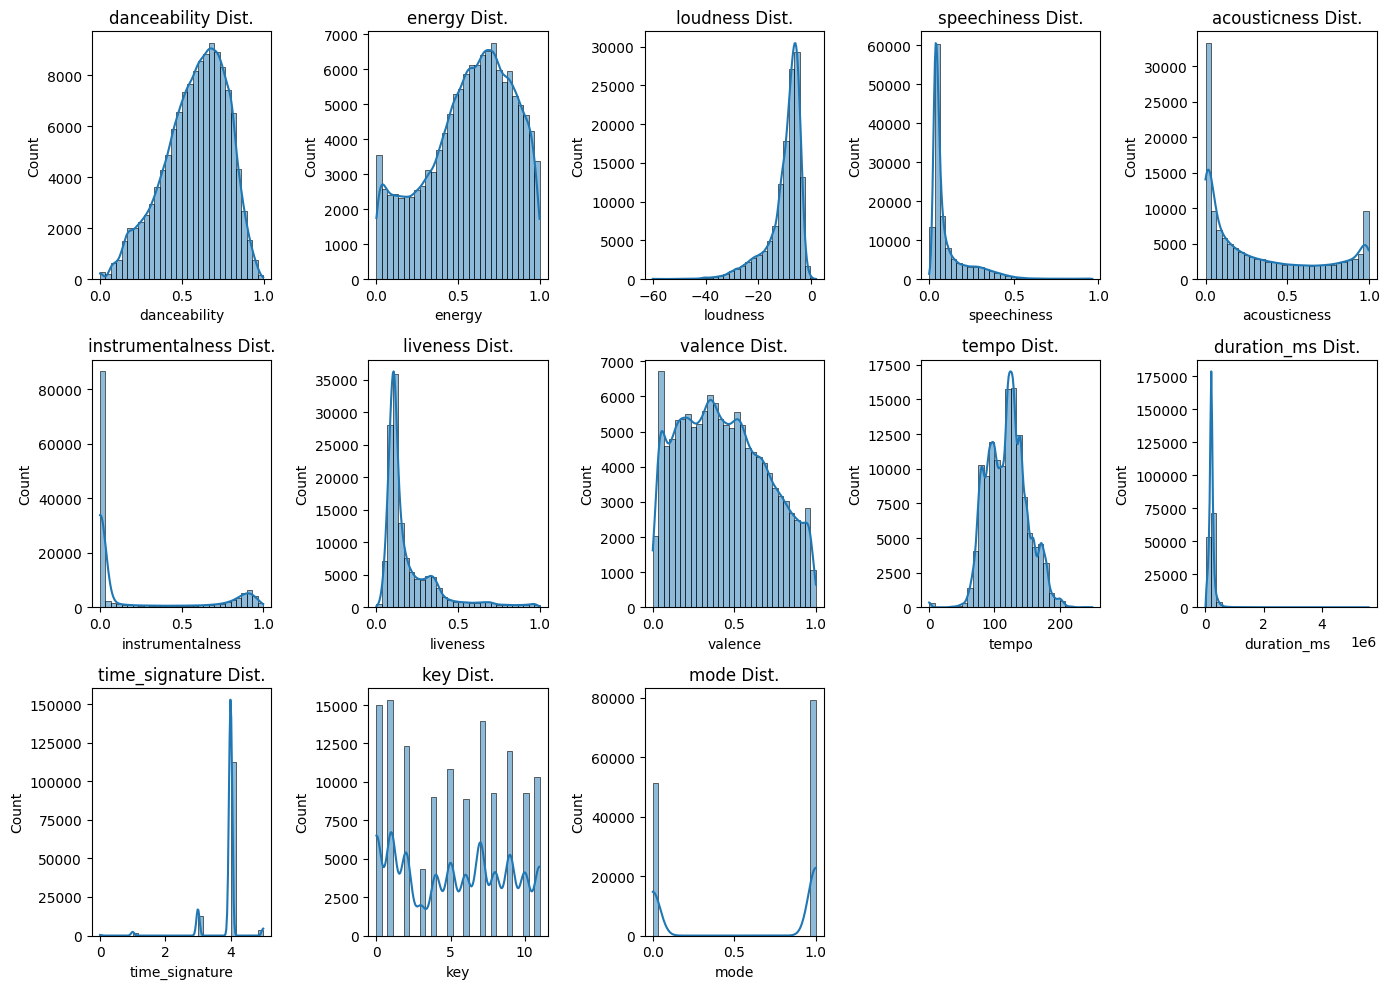

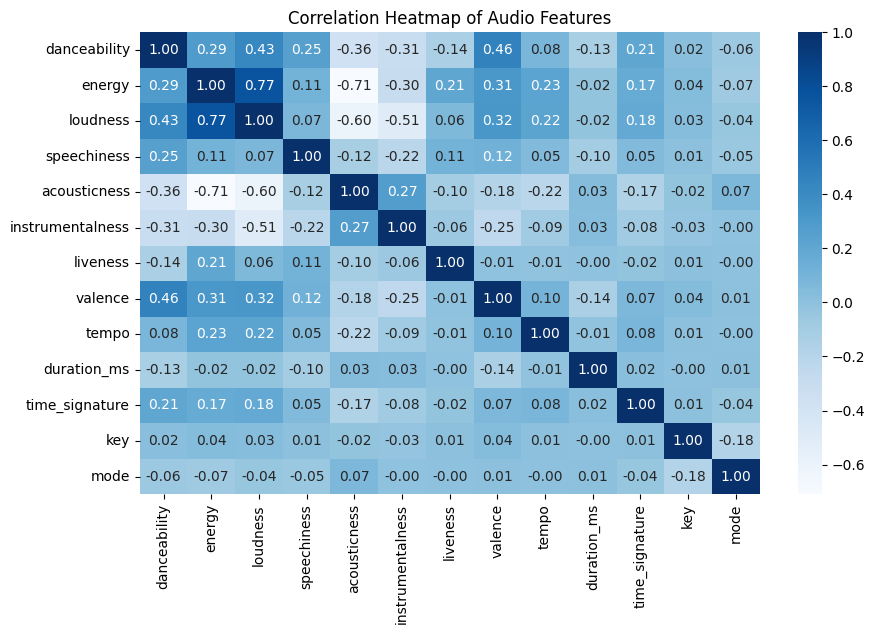


--- SINGLE-SEED RECOMMENDER: POPULARITY-HEAVY ---

Please enter 1 seed track + artist.
Track Name: bad guy
Artist Name: billie
Possible tracks for 'bad guy':
1. bad guy
2. bad guys
3. a bad guy
4. the bad guy
5. bad fun
6. bad day
7. bad boy
8. good guy
9. bread up
10. bands up
11. baldy
12. baddy
13. bad year
14. bad song
15. bad luck
Pick track # (or Enter to skip): 1
You chose => 'bad guy'
Auto-chosen => 'bad guy' by 'Billie Eilish'
Seed located: artist_name                  Billie Eilish
track_id            2Fxmhks0bxGSBdJ92vM42m
track_name                         bad guy
acousticness                         0.308
danceability                         0.708
duration_ms                         194088
energy                               0.418
instrumentalness                     0.093
key                                      0
liveness                               0.1
loudness                           -10.998
mode                                     1
speechiness                  

In [3]:


import difflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


# (1)

df = pd.read_csv("SpotifyAudioFeaturesApril2019.csv")

print("Data Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))

# Potential numeric columns (adjust if your CSV differs)
numeric_cols = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo",
    "duration_ms", "time_signature", "key", "mode",
    "track_popularity"  # rename if your dataset calls it "popularity"
]

# Keep only columns that exist & drop missing data
final_features = [c for c in numeric_cols if c in df.columns]
df["track_name"] = df["track_name"].astype(str).str.lower()
df = df.dropna(subset=["track_name"])
df = df.dropna(subset=final_features)

# OPTIONAL: Simple mood classification
def classify_mood(val, ener):
    if val >= 0.6 and ener >= 0.6:
        return "Happy"
    elif val <= 0.3 and ener <= 0.3:
        return "Sad"
    elif ener >= 0.75:
        return "Energetic"
    else:
        return "Chill"

if "valence" in df.columns and "energy" in df.columns:
    df["mood"] = df.apply(lambda row: classify_mood(row["valence"], row["energy"]), axis=1)


# (2)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[final_features])

feature_weights = {
    "valence": 1.5,
    "energy": 1.2,
    "track_popularity": 0.8
}
for i, col in enumerate(final_features):
    if col in feature_weights:
        scaled_data[:, i] *= feature_weights[col]

knn_model = NearestNeighbors(n_neighbors=300, metric="cosine")
knn_model.fit(scaled_data)

df = df.reset_index(drop=True)
df["knn_index"] = np.arange(len(df))

# 3
def plot_feature_distributions():
    """Histograms of each numeric feature."""
    plt.figure(figsize=(14, 10))
    for i, feat in enumerate(final_features, 1):
        plt.subplot(3, 5, i)
        sns.histplot(df[feat], kde=True, bins=30)
        plt.title(f"{feat} Dist.")
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap():
    """Correlation matrix among final_features."""
    plt.figure(figsize=(10, 6))
    corr = df[final_features].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
    plt.title("Correlation Heatmap of Audio Features")
    plt.show()

# 4
def fuzzy_match_list(user_input: str, possible_values: list, cutoff: float, top_n: int = 15):
    """Use difflib.get_close_matches to get partial matches."""
    return difflib.get_close_matches(user_input, possible_values, n=top_n, cutoff=cutoff)

def find_best_match(user_input: str, possible_values: list):

    user_input = user_input.strip().lower()
    # attempt cutoff=0.4
    matches = fuzzy_match_list(user_input, possible_values, cutoff=0.4, top_n=15)
    if matches:
        return matches
    # fallback cutoff=0.2
    matches = fuzzy_match_list(user_input, possible_values, cutoff=0.2, top_n=15)
    if matches:
        return matches
    # final fallback => substring
    sub_matches = [v for v in possible_values if user_input in v.lower()]
    return sub_matches

def locate_song_interactive(user_track: str, user_artist: str):
    """
    1) For the track name, get partial/fallback matches => user picks from a list.
    2) Then among that track's rows, do the same for the artist => user picks.
    3) Returns a single df row or None if no match / user skip.
    """
    user_track = user_track.lower().strip()
    user_artist = user_artist.lower().strip()

    # Step A: track_name
    unique_tracks = df["track_name"].unique().tolist()
    track_matches = find_best_match(user_track, unique_tracks)
    if not track_matches:
        print(f"No matches found for track '{user_track}'. Skipping.")
        return None

    if len(track_matches) == 1:
        chosen_track = track_matches[0]
        print(f"No direct match => using partial => '{chosen_track}'")
    else:
        print(f"Possible tracks for '{user_track}':")
        for i, t in enumerate(track_matches, 1):
            print(f"{i}. {t}")
        t_choice = input("Pick track # (or Enter to skip): ")
        if not t_choice.strip():
            print("No selection. Skipping.")
            return None
        try:
            idx = int(t_choice)
            if 1 <= idx <= len(track_matches):
                chosen_track = track_matches[idx - 1]
                print(f"You chose => '{chosen_track}'")
            else:
                print("Invalid choice. Skipping.")
                return None
        except ValueError:
            print("Not a valid integer. Skipping.")
            return None

    sub_df = df[df["track_name"] == chosen_track]
    if sub_df.empty:
        print(f"Unexpected: no rows found for track => '{chosen_track}'.")
        return None

    # Step B: artist_name
    unique_artists = sub_df["artist_name"].unique().tolist()
    artist_matches = find_best_match(user_artist, unique_artists)
    if not artist_matches:
        print(f"No artist matches for '{user_artist}'. Available =>")
        for i, art in enumerate(unique_artists, 1):
            print(f"{i}. {art}")
        a_choice = input("Pick artist # (or Enter to skip): ")
        if not a_choice.strip():
            print("No selection. Skipping.")
            return None
        try:
            aidx = int(a_choice)
            if 1 <= aidx <= len(unique_artists):
                final_art = unique_artists[aidx - 1]
                row_candidates = sub_df[sub_df["artist_name"] == final_art]
                row = row_candidates.iloc[0]
                print(f"You chose => '{row['track_name']}' by '{row['artist_name']}'")
                return row
            else:
                print("Invalid. Skipping.")
                return None
        except ValueError:
            print("Not a valid integer. Skipping.")
            return None
    else:
        if len(artist_matches) == 1:
            chosen_art = artist_matches[0]
            row_candidates = sub_df[sub_df["artist_name"] == chosen_art]
            if row_candidates.empty:
                row_candidates = sub_df[sub_df["artist_name"].str.lower().str.contains(chosen_art.lower())]
                if row_candidates.empty:
                    print(f"No row found for artist => '{chosen_art}'. Skipping.")
                    return None
                else:
                    row = row_candidates.iloc[0]
                    print(f"Auto-chosen => '{row['track_name']}' by '{row['artist_name']}'")
                    return row
            else:
                row = row_candidates.iloc[0]
                print(f"Auto-chosen => '{row['track_name']}' by '{row['artist_name']}'")
                return row
        else:
            print(f"Possible artists for '{user_artist}':")
            for i, a in enumerate(artist_matches, 1):
                print(f"{i}. {a}")
            a_choice = input("Pick artist # (or Enter to skip): ")
            if not a_choice.strip():
                print("No selection. Skipping.")
                return None
            try:
                aidx = int(a_choice)
                if 1 <= aidx <= len(artist_matches):
                    chosen_art = artist_matches[aidx - 1]
                    row_candidates = sub_df[sub_df["artist_name"] == chosen_art]
                    if row_candidates.empty:
                        row_candidates = sub_df[sub_df["artist_name"].str.lower().str.contains(chosen_art.lower())]
                        if row_candidates.empty:
                            print("No row found. Skipping.")
                            return None
                        else:
                            row = row_candidates.iloc[0]
                            print(f"Final => '{row['track_name']}' by '{row['artist_name']}'")
                            return row
                    else:
                        row = row_candidates.iloc[0]
                        print(f"Final => '{row['track_name']}' by '{row['artist_name']}'")
                        return row
                else:
                    print("Invalid choice. Skipping.")
                    return None
            except ValueError:
                print("Not a valid integer. Skipping.")
                return None


# (5)
def single_seed_recommend(seed_row, mood_filter=None, n_recs=5):
    """
    Steps:
    1) Use the single seed's scaled vector => top 300 neighbors => optional mood filter.
    2) final_score = (1 - distance) + 2.0 * pop_scaled => popularity can overshadow closeness.
    3) Return top n. Output only track_name + artist_name.
    """
    if seed_row is None:
        return "No valid seed."

    seed_idx = seed_row["knn_index"]
    seed_vec = scaled_data[seed_idx].reshape(1, -1)

    distances, indices = knn_model.kneighbors(seed_vec, n_neighbors=300)
    neighbor_idx = indices[0]
    neighbor_dist = distances[0]

    neighbor_df = df.iloc[neighbor_idx].copy()
    neighbor_df["distance"] = neighbor_dist

    # Exclude the seed track
    neighbor_df = neighbor_df[neighbor_df["knn_index"] != seed_idx]

    # Mood filter
    if mood_filter and "mood" in neighbor_df.columns:
        filtered = neighbor_df[neighbor_df["mood"].str.lower() == mood_filter.lower()].copy()
        if filtered.empty:
            print(f"[Fallback] No neighbors matched mood='{mood_filter}'. Returning unfiltered.")
        else:
            neighbor_df = filtered

    # final_score
    alpha = 2.0
    if "track_popularity" in neighbor_df.columns:
        neighbor_df["pop_scaled"] = neighbor_df["track_popularity"] / 100.0
        neighbor_df["final_score"] = (1 - neighbor_df["distance"]) + alpha * neighbor_df["pop_scaled"]
    else:
        neighbor_df["final_score"] = 1 - neighbor_df["distance"]

    neighbor_df = neighbor_df.sort_values("final_score", ascending=False)

    # Return only track_name + artist_name
    return neighbor_df.head(n_recs)[["track_name", "artist_name"]]

# (6) MAIN

if __name__ == "__main__":
    # Plot EDA
    plot_feature_distributions()
    plot_correlation_heatmap()

    print("\n--- SINGLE-SEED RECOMMENDER: POPULARITY-HEAVY ---\n")

    # 1) Collect 1 seed
    print("Please enter 1 seed track + artist.")
    track_in = input("Track Name: ")
    artist_in = input("Artist Name: ")
    seed = locate_song_interactive(track_in, artist_in)

    # Then proceed with whatever you want to do using 'seed'
    print(f"Seed located: {seed}")


    # 2) Optional mood
    mood_in = input("\nAny mood preference? (Sad, Happy, Energetic, Chill, or Enter for none): ").strip()
    mood_in = mood_in if mood_in else None

    if seed is None:
        print("\nNo valid seed. Exiting.")
    else:
        # 3) Recommend
        recs = single_seed_recommend(seed, mood_filter=mood_in, n_recs=5)
        print("\nRECOMMENDATIONS:\n", recs)

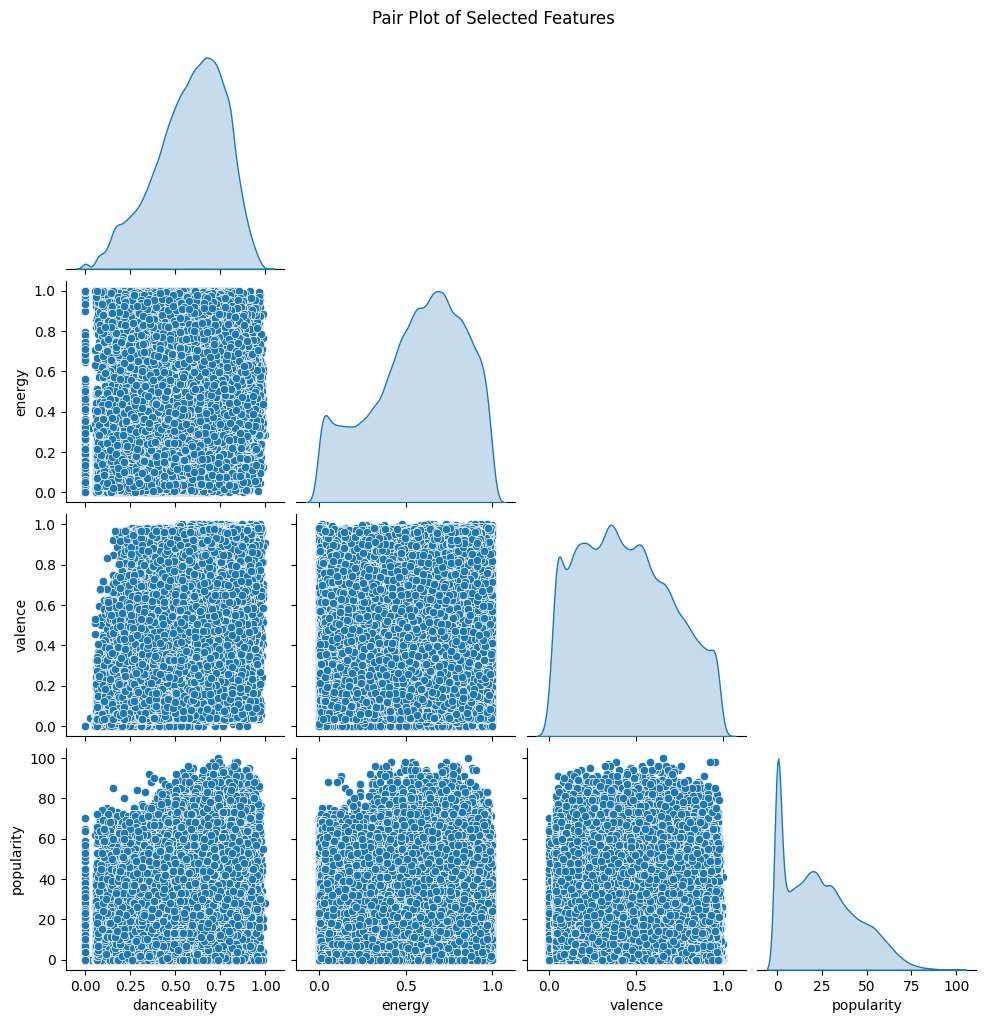

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose your CSV is named 'spotify_data.csv'
# Adjust the path/filename as necessary
df = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')

# Select a subset of columns for pairwise comparison
cols_of_interest = ['danceability', 'energy', 'valence', 'popularity']

# Create pair plot
sns.pairplot(df[cols_of_interest], diag_kind='kde', corner=True)
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()


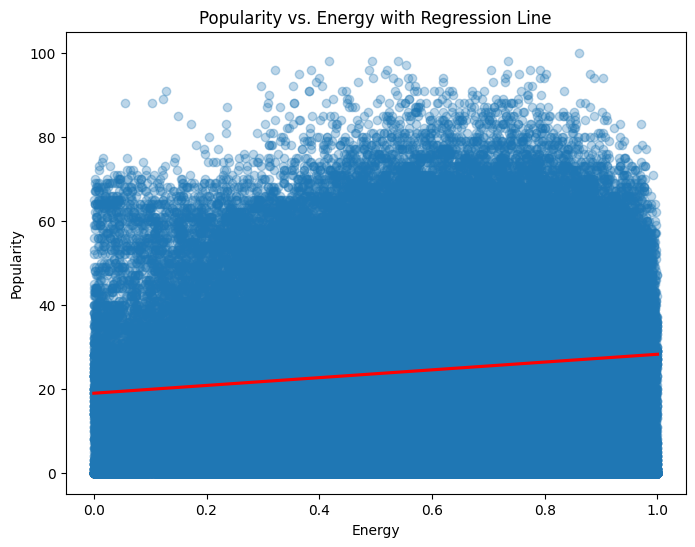

In [6]:
plt.figure(figsize=(8,6))
sns.regplot(x='energy', y='popularity', data=df, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title("Popularity vs. Energy with Regression Line")
plt.xlabel("Energy")
plt.ylabel("Popularity")
plt.show()

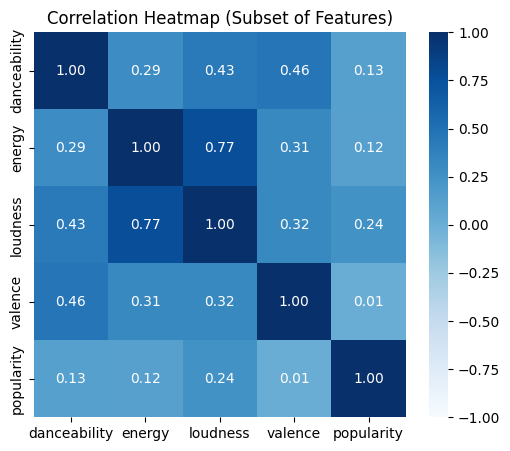

In [7]:
top_features = ['danceability', 'energy', 'loudness', 'valence', 'popularity']
corr_matrix = df[top_features].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Subset of Features)")
plt.show()


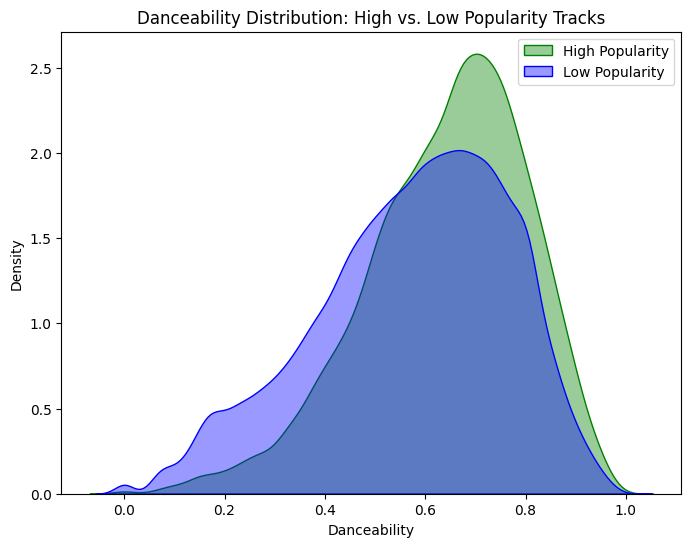

In [8]:
# Define popularity thresholds (example only)
high_pop = df[df['popularity'] >= 50]
low_pop = df[df['popularity'] < 50]

# Compare distribution of danceability for high-pop vs. low-pop
plt.figure(figsize=(8,6))
sns.kdeplot(data=high_pop['danceability'], fill=True, color='green', alpha=0.4, label="High Popularity")
sns.kdeplot(data=low_pop['danceability'], fill=True, color='blue', alpha=0.4, label="Low Popularity")
plt.title("Danceability Distribution: High vs. Low Popularity Tracks")
plt.xlabel("Danceability")
plt.legend()
plt.show()
